In [1]:
import numpy as np
from math import *
import random
import cv2
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats
import time

C:\Users\kikiy\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kikiy\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\kikiy\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
## single guess -- (x,y,theta) where "theta" is the heading direction
class robot:
    def __init__(self):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * pi
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
        self.get_x         = 0.0
        self.get_y         = 0.0
        self.get_orientation = 0.0
    
    def set_xy(self, new_x, new_y):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        self.x = float(new_x)
        self.y = float(new_y)  
        #used in get_state function
        self.get_x = self.x
        self.get_y = self.y
    
    def set_orientation(self,orientation):
        if orientation < -2*pi or orientation >= 2 * pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.orientation = float(orientation)
        angle = self.orientation
        return angle
            
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    def sense(self,landmarks):
        Z = []
        x,y,orientation = self.get_state()    #get current state of robot
        for i in range(len(landmarks)):
            dist = sqrt((x - landmarks[i][0]) ** 2 + (y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def sensor_range(self,robot_radius,sensor_radius):
        x,y,orientation = self.get_state()    #get current state of robot
        deg_val = np.rad2deg(orientation)
        #offset for drawing sensor range circle
        x_off = cos(orientation) * robot_radius + x
        y_off = sin(orientation) * robot_radius + y
        #sensor radius offset
        sr_x = cos(orientation) * sensor_radius + x
        sr_y = sin(orientation) * sensor_radius + y
        return [x,y,x_off,y_off,sr_x,sr_y,orientation]

    def get_nearest_landmarks(self,landmarks,sensor_radius):
        np_landmarks = np.array(landmarks)
        #you have a circle and you're checking what obstacles fall in that circle
        # This is my process for finding the obstacles in the sensor_range
        landmarks_copy = np_landmarks.copy()
        x_vals = landmarks_copy[0:,0:1]          #get values on x-side
        y_vals = landmarks_copy[0:,1:2]          #get values on y-side
        
        # obstacles outside the radius were being sensed.easiest solution is this
        percent_reduction = 1.2
        reduced_radius = percent_reduction * sensor_radius 
        
        #check for values in between upper and lower bounds of the circle based on the sensor radius
        check_x_upper = (x_vals < (val[4] + reduced_radius))
        check_y_upper = (y_vals < (val[5] + reduced_radius))
        check_x_lower = (x_vals > (val[4] - reduced_radius))
        check_y_lower = (y_vals > (val[5] - reduced_radius))

        # get inter values
        check_x = check_x_upper * check_x_lower * x_vals
        check_y = check_y_upper * check_y_lower * y_vals
        #assign the values to the array
        np_landmarks[0:,0:1] = check_x
        np_landmarks[0:,1:2] = check_y

        sensed_landmarks = []
        #truncate array and select only qualifying landmarks
        [sensed_landmarks.append([x,y]) for x,y in np_landmarks if (x > 0 and y > 0)]  
        return sensed_landmarks
    
    def show_close_landmarks(self,sensed_landmarks,landmark_size,world_img):
        #draw new color for sensed obstacles
        x_i,y_i,ori = self.get_state()
        color = (0,255,0)
        for x,y in sensed_landmarks:
            cv2.line(world_img,(int(x_i),int(y_i)),(int(x),int(y)),color,1)
        return world_img
    
    def get_state(self):  # used to get robot location for obstacle avoidance
        return self.x,self.y,self.orientation
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')         
        
        orientation = self.set_orientation(turn) + random.gauss(0.0, self.turn_noise) #set orientation

        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (cos(orientation) * dist)
        y = self.y + (sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size
        
        #used in get state function
        self.x = x
        self.y = y
        self.orientation = orientation
        
        # set particle
        res = robot()
        res.set_xy(x, y)
        res.set_orientation(orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
            
        
    def Gaussian(self, mu, sigma, x): #probability density function ... not in use
#         print(mu,sigma,x)
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        results = exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))
        return results
    
    
    def measurement_prob(self,measurement,landmarks):
        #used for creating importance weights, check how likely/accurate the measurement is and return probability
        # calculates how likely a measurement should be
        prob = 1.0;
        R = 60    #uncertainty variable / variance   //gets more acurrate when increased
        for i in range(len(landmarks)):
            #dist becomes sensor from the robot and "measurement" is the measurement from the particle
            dist = sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
#             prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
            prob *= scipy.stats.norm(dist, R).pdf(measurement[i])    #get weight values based off landmark distances
        return prob
    
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))



def eval(r, p):
    sum = 0.0;
    for i in range(len(p)): # calculate mean error
        #world size and the modulo symbol is just gymnastics for dealing with the cyclic world
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))


def display_distances(img,dist):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.4
    color = (0, 255, 255)
    thickness = 1
    for i,d in enumerate(dist):   #distances is a list,,iterate through and display
        text = 'distance_'+str(i)+": " + str('%.2f' % d)
        loc = (2,((i+1)*15)) 
        image = cv2.putText(img, text, loc, font, fontScale, color, thickness, cv2.LINE_AA, False)
    return img

def avoid_obstacle(threshold,sensed_landmarks,dist):
    #obstacle avoidance
    change_orientation = False
    dist = np.array(dist)
    sensed_landmarks = np.array(sensed_landmarks)
    if dist.size > 0:
        min_dist = np.min(dist)         #get minimum distance
        if min_dist < threshold:
            change_orientation = True    # if obstacle is too close set boolean to true
            
    return change_orientation

def draw_particles(particles,world_img):
    color = (255,255,255)
    radius = 2
    for p in particles:
        x,y,_ = p.get_state()
        cv2.circle(world_img,(int(x),int(y)),radius,color,-1)   #draw robot
    return world_img


def systematic_resample(weights):
    N = len(weights)    #get length of weights
    positions = (np.arange(N) + np.random.random()) / N #create a positions list from 0-N add a random value and normalize
    indexes = np.zeros(N, 'i')       #create an index array of int zeros
    cumulative_sum = np.cumsum(weights) #return the cumulative sum of the weights thus the total sum of the weights as it grows with time
    i, j = 0, 0
    while i < N and j<N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def resample_from_index(particles, weights, indexes): #collect indexes of resampled weights.
    p,w = [], []
    [p.append(particles[i]) for i in indexes]
    [w.append(weights[i]) for i in indexes]
    particles = p
    weights = w
    weights /= np.sum(weights)  #normalize the weights..IMPORTANT
    return particles

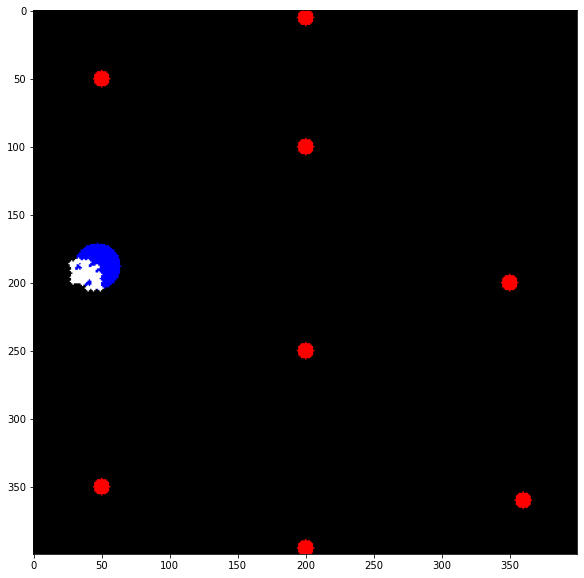

In [3]:
img = cv2.imread("landmarks.png")
world_size = 400
img = cv2.resize(img,(world_size,world_size)) #resize image to a square image

landmarks = [[200, 100], [360, 360], [50, 50], [200, 250], [50, 350], [350, 200], [200, 5], [200, 395]]

#particle data
num_of_particles = 100
particles = []
#create the specified number of robot particles
for i in range(num_of_particles):
    p = robot()
    p.set_noise(0.05, 0.05, 3.0)  #noise for particles
    particles.append(p)
    

# Create a VideoWriter object
output_file = "particle_filter" + str(random.randint(0,3000)) + ".avi"
fps = 2
video_size = (img.shape[0],img.shape[1])
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
save_output = cv2.VideoWriter(output_file,  fourcc, fps, video_size) 


#colors
obstacle_color = (255,0,0)     #red
robot_color = (0,0,255)        #blue
heading_color = (255,255,255)   #white
sensor_color = (255,255,0)

landmark_size = 6     #landmark circle size in image
for (x,y) in landmarks:
    cv2.circle(img,(int(x),int(y)),landmark_size,obstacle_color,-1)

#initiate robot location
init_start_x = 150      
init_start_y = 200 
init_orientation = random.uniform(0,2*pi)    #begin with random orientation

#init radii
robot_radius = 17    #robot size
sensor_radius = robot_radius + 40  #add robot radius
obstacle_avoid_threshold = robot_radius + 15      #obstacle avoidance threshold

#Initiate robot object
myrobot = robot()
myrobot.set_xy(init_start_x, init_start_y) # I need this so robot isn't spawned on a landmark location
myrobot.set_noise(0.01,0.01,2.0)   # add noise

move_speed = 10.0
robot_angle = init_orientation

while(True):
    #create a new copy of the image on every iteration so changes to the image arent permanent
    world_img = img.copy()  
    
    val = myrobot.sensor_range(robot_radius,sensor_radius)  # val = [x,y,x_off,y_off,sr_x,sr_y,orientation]
    x,y,orientation= val[0],val[1],val[6]   #robot states
    x_offset,y_offset= val[2],val[3]   #offset to edge of robot
    
    #draw robot and heading and sensor range
    cv2.circle(world_img,(int(x),int(y)),robot_radius,robot_color,-1)   #draw robot
    cv2.line(world_img,(int(x),int(y)),(int(x_offset),int(y_offset)),heading_color,2)  #draw heading line
#     cv2.circle(world_img,(int(val[4]),int(val[5])),sensor_radius,sensor_color,1)   #draw sensor range
    
    sensed_landmarks = myrobot.get_nearest_landmarks(landmarks,sensor_radius)
    world_img = myrobot.show_close_landmarks(sensed_landmarks,landmark_size,world_img)
    
    #get distances and check for obstacles
    dist = myrobot.sense(sensed_landmarks)
    dist_all = myrobot.sense(landmarks)
    change_direction = avoid_obstacle(obstacle_avoid_threshold,sensed_landmarks,dist)    # check if obstacle is too close

    if change_direction:   #if obstacle is too close
        robot_angle = random.uniform(0,2*pi)   #turn random orientation
    
    myrobot.move(robot_angle,move_speed)  #move robot  ...to move the robot you have to independently increase the variables

    #apply robot movement to particles
    p2 = []
    for i in range(num_of_particles):
        p2.append(particles[i].move(robot_angle,move_speed)) #apply robot movement to particles
    particles = p2

    #get weight measurement of particles based of distances from landmarks
    weights = []
    for i in range(num_of_particles):
        temp_w = particles[i].measurement_prob(dist_all,landmarks) #get particle weights
        weights.append(temp_w)
    weights /= sum(weights)   #  really important to normalize
        

    world_img = draw_particles(particles,world_img)   # display particles
    world_img = display_distances(world_img,dist)  #display distances

    
    #resampling particles
    indexes = systematic_resample(weights)
    particles = resample_from_index(particles, weights, indexes)

    save_output.write(world_img)     #save video
    cv2.imshow("frame",world_img)  #show image
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

        
save_output.release()
cv2.destroyAllWindows()

plt.figure(figsize=(10,10))
plt.imshow(world_img)


### This project is inspired by the udacity partile filter course <br/>

https://classroom.udacity.com/courses/cs373/lessons/48704330/concepts/487550370923 <br/><br/>
http://ros-developer.com/2019/04/10/parcticle-filter-explained-with-python-code-from-scratch/

In [12]:
pos = np.zeros(10)
print(pos)
# print

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
